# Imports

In [22]:
import pysweep
import qcodes as qc
import pysweep.databackends.debug
import pysweep.databackends.list_backend
import pysweep.databackends.qcodes
import pysweep.core.measurementfunctions
from pysweep.core.sweepobject import SweepObject
from pysweep.core.measurementfunctions import MakeMeasurementFunction
from pysweep.databackends.base import DataParameterFixedAxis
import pysweep.convenience as conv
import random
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
from pysweep.databackends.base import DataParameter
from pytopo.qctools.dataset2 import select_experiment
from qcodes.dataset.measurements import Measurement

from qcodes import load_by_id
import qcodes as qc
import qcodes.dataset.plotting
import importlib

C:\Anaconda3\envs\measurement-env\lib\site-packages\qcodes\dataset\sqlite_base.py:51: UserWarning: The module `qcodes.dataset.sqlite_base` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.sqlite_base` is deprecated.\n'


In [3]:
station = qc.Station()
pysweep.STATION = station
qc.config.core.db_location = r'D:\OneDrive\BF1\Code\pysweep\testdata.db'
qc.initialise_database()

# Define a few parameters with physics

In [21]:
# Define dummy parameters representing DC bias and two gate voltages
bias = qc.instrument.parameter.ManualParameter("bias", units="V")
T1 = qc.instrument.parameter.ManualParameter("T1", units="V")
T2 = qc.instrument.parameter.ManualParameter("T2", units="V")

# Set the dummy parameters
bias(0)
T1(0)
T2(0)

# Helper function to generate a shape of a pinch off for fake measurement
def pinchoff(v, rs=10e3, l=2e-6, muc=3*60e-18, vth=-1):
    if v>vth:
        return (rs+l**2/(muc*(v-vth)))
    else:
        return 1e11

# Gettable parameter that represents a measured quantity
def get_current():
    u = bias()
    r = pinchoff(T1())+pinchoff(T2())
    return u/r
current = qc.instrument.parameter.Parameter("current", units="A", get_cmd=get_current)

# Other gettable parameter
def S21(f):
    s21 = 5e6**2/(5e6**2+(f-100e6)**2)
    c = 1/(pinchoff(T1())+pinchoff(T2()))
    s21 *= np.exp(-c/10e-6)
    return 1-s21


# Define the functions that define the measurement

We need to define what happens at the start of a measurement, what must happen at the end of a measurement and finally what a measurement entails

## Initialization and end functions

In [5]:
# A function that will be called before the beginning of the measurement loop to prepare a setup
def init_measurement(d):
    bias(1e-3)

# A function that will be called after the end of the measurement loop to bring
# the setup back to neutral configuration
def end_measurement(d):
    bias(0)

## Measurement functions

In [6]:
# The parameter to be measured is wrapped to a format compatible with pysweep

#                          name       unit
@MakeMeasurementFunction([['current', 'A']])
def measure(d):
    return [current()] # list of measurement outcomes

#                          name       unit    name          unit
@MakeMeasurementFunction([['current', 'A'], ['conductance', 'S']])
def measure_two_parameters(d):
    c = current()
    b = bias()
    return [c, c/b] # list of measurement outcomes

lets also define a function the measures the hypothetical temperature of our fridge

In [7]:
@MakeMeasurementFunction([['Temperature', 'mK']])
def measure_temperature(d):
    return [random.randint(100, 300)/10]

# Simple measurements

This paragraph contains some measurements that corresponds to the easiest cases of measurements. The cases cover 90% of all measurements that will run, but don't show the full power of pysweep

## Basic 1D sweep

In [8]:
# check for existing experiment in the selected database, and create one if needed
exp = select_experiment('pinchoff', 'test_sample')
# create a QCoDeS measurement object
meas = Measurement(exp, station)

# the measurement loop
r = pysweep.sweep(init_measurement, # function executed before the beginning of the loop
              end_measurement,      # function executed after the end of the loop
              measure,              # measurement to be executed at each iteration
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)),  # specifies the parameter to loop over and a range
              databackend = pysweep.databackends.qcodes.DataBackend(meas) # selects the databackend to send the data to
            )

None3 , postponing registration
None2 , postponing registration
Starting experimental run with id: 1


([<matplotlib.axes._subplots.AxesSubplot at 0x1c173248>], [None])

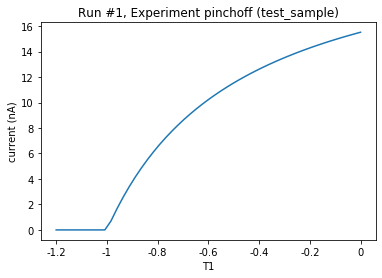

In [10]:
# plot the measured data
qcodes.dataset.plotting.plot_by_id(r.datasaver.run_id)

## Basic 2D sweep

In [13]:
# get the measurement object
exp = select_experiment('pinchoff', 'test_sample')
meas = Measurement(exp, station)

# run the 2D sweep
r = pysweep.sweep(init_measurement,
                  end_measurement,
                  measure_two_parameters, 
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
              pysweep.sweep_object(T2, np.linspace(0,-1.2,51)), 
              databackend = pysweep.databackends.qcodes.DataBackend(meas)
            )

None3 , postponing registration
Starting experimental run with id: 3


([<matplotlib.axes._subplots.AxesSubplot at 0x1d7e0788>,
  <matplotlib.colorbar.Colorbar at 0x1dbe2948>])

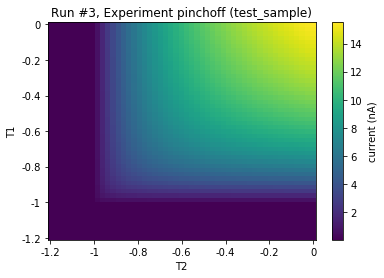

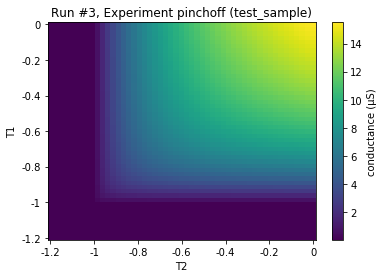

In [15]:
# plot the two measured quantities
qcodes.dataset.plotting.plot_by_id(r.datasaver.run_id)

# Extended examples

Here are a few examples of measurements that are still relatively simples, but with a few more bells and whistles

Say that we want to measure the fridge temperature in addition to the current, then we simply execute

## Addition of measurement functions

In [16]:
exp = select_experiment('pinchoff', 'test_sample')
meas = Measurement(exp, station)

r = pysweep.sweep(init_measurement,
                  end_measurement,
                  measure+measure_temperature, # measurement functions support addition
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
              pysweep.sweep_object(T2, np.linspace(0,-1.2,51)), 
              databackend=pysweep.databackends.qcodes.DataBackend(meas)
            )

None3 , postponing registration
Starting experimental run with id: 4


([<matplotlib.axes._subplots.AxesSubplot at 0x1dc69f88>,
  <matplotlib.colorbar.Colorbar at 0x1d86eac8>])

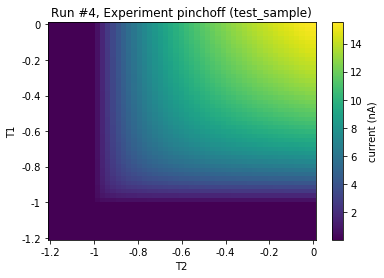

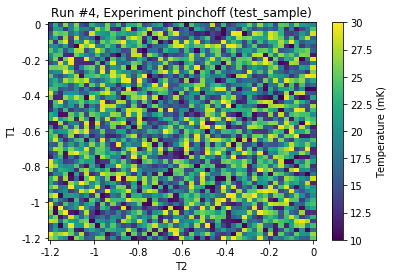

In [17]:
qcodes.dataset.plotting.plot_by_id(r.datasaver.run_id)

## Measurements in the outer measurement loop

But often we only want to measure temperature every now and then, so let's assume that we want to measure the fridge tmeperature only after every time we set the T2 parameter

In [18]:
exp = select_experiment('pinchoff', 'test_sample')
meas = Measurement(exp, station)
r = pysweep.sweep(init_measurement,
                  end_measurement,
                  measure, 
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
              conv.add_function(pysweep.sweep_object(T2, np.linspace(0,-1.2,51)), measure_temperature), 
              databackend = pysweep.databackends.qcodes.DataBackend(meas)
            )

None3 , postponing registration
Starting experimental run with id: 5


([<matplotlib.axes._subplots.AxesSubplot at 0x1e152948>,
 [None, <matplotlib.colorbar.Colorbar at 0x1d787bc8>])

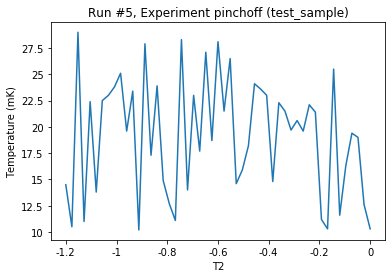

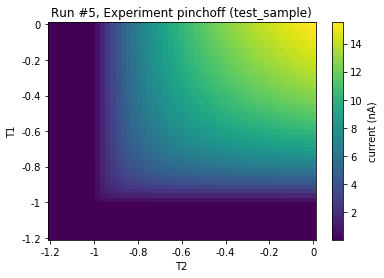

In [19]:
qcodes.dataset.plotting.plot_dataset(r.datasaver.dataset)

## Measurement functions returning an array of coordinates and array of data

Several instruments internally perform a 1D (or multi-D) sweep and return an array values. For example VNA will return an array representing full dependence S21(f), which we may want to repeat as a function of some other parameter.

In [24]:
# A function that creates a measurement function
def transmission_vs_frequency(frequency_sweep_range):
    
    # create a pysweep data parameter reperesenting a frequency
    # it is neccesary to ensure that it is treated as an independent variable
    frequency_parameter = DataParameterFixedAxis('Frequency',
                                        'Hz',
                                        'array',
                                        frequency_sweep_range)
    
    #                        data parameter
    #                        for independent
    #                        variable               name    unit       type
    @MakeMeasurementFunction([frequency_parameter, ['S21', 'arb. u.', 'array']])
    def transmission_vs_frequency_measurement_function(d):
        measured_S21 = S21(frequency_sweep_range)
        return [frequency_sweep_range, measured_S21]
    
    # return a measurement function
    return transmission_vs_frequency_measurement_function

In [25]:
exp = select_experiment('pinchoff', 'test_sample')
meas = Measurement(exp, station)

T1(0)
T2(0)

# let's measure current and transmission
r = pysweep.sweep(init_measurement,
                  end_measurement,
                  measure+transmission_vs_frequency(np.linspace(80e6,120e6)), # a measurement function that returns anarray must be last to be added
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
              databackend=pysweep.databackends.qcodes.DataBackend(meas)
            )

None3 , postponing registration
None2 , postponing registration
Starting experimental run with id: 6


([<matplotlib.axes._subplots.AxesSubplot at 0x1e107a08>,
 [None, <matplotlib.colorbar.Colorbar at 0x1df08e08>])

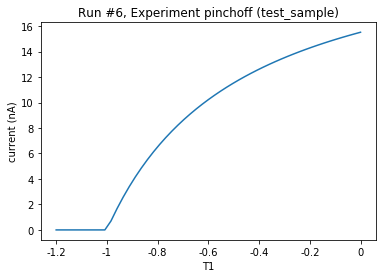

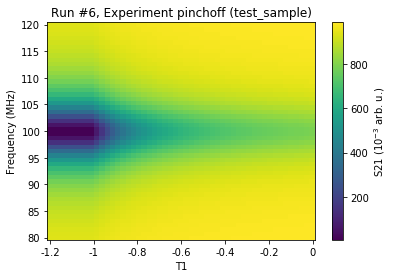

In [26]:
qcodes.dataset.plotting.plot_dataset(r.datasaver.dataset)

# Adaptive sweep - under construction

In [ ]:
@MakeMeasurementFunction([['timestamp', 's']])
def smart_point_function(dict_waterfall):
    timestamp = int(time.time())
    points = [int(c) for c in str(timestamp)]
    return points, [timestamp]

In [ ]:
db = pysweep.databackends.debug.DebugDataBackend()
pysweep.sweep(lambda d:{}, lambda d:{}, measure, 
              pysweep.sweep_object(a, [0,1]),
              conv.add_function(pysweep.sweep_object(b, [3,4]), measure_temperature),
              pysweep.sweep_object(c, smart_point_function, dataparameter=np.linspace(0,9,10)), databackend=db
             )

# Real life example - under construction

In [ ]:
%%enqueue single_shot_readout
exp = select_experiment('blobs', SAMPLE)
meas = Measurement(exp, station)
singleshot_dataextractor.setup_acquisition(1024, 1000, 100)
#4.77946e9
parameter_list = [[station.TI.NW_bias, 0e-3], [station.HT.frequency, 4779770000], [station.HT.RF.power, -20.25]]

pysweep.sweep(sf.set_parameters_after(init_rf, parameter_list), end_rf, 
              measure_singleshot_rf,
              pysweep.sweep_object(station.TI.SP4, snr_calibrate_plunger(pysweep.sweep_object(station.TI.SP4, np.linspace(0., 0.4, 101))), dataparameter=[0,1]),
              pysweep.convenience.add_function(pysweep.sweep_object(station.TI.T5, np.linspace(-1, -1.35, 101)), csc),
              databackend = pysweep.databackends.qcodes.DataBackend(meas)
             )
rigol.ch1_output_enabled(False)

# Jagged Data Structures - under construction

In [ ]:
?DataParameter

In [ ]:
@MakeMeasurementFunction([DataParameter('time', 's', 'array', 2),
                         DataParameter('first_gate', 'V', 'array', 2),
                         DataParameter('second_gate', 'V', 'array', 2),
                         DataParameter('first_gate_result', 'I', 'array', extra_dependencies=['time', 'first_gate']),
                         DataParameter('time', 's', 'array', 2, duplicate=True),
                         DataParameter('second_gate_result', 'I', 'array', extra_dependencies=['time', 'second_gate'])])
def some_arbitrary_data(d):
    return [np.linspace(0,1, 11), np.linspace(0,0.1, 11), np.linspace(0,-0.1, 21), np.linspace(0,0.2, 11), np.linspace(1,2, 21), np.linspace(0,-0.2, 21)]

In [ ]:
importlib.reload(pysweep.databackends.qcodes)

In [ ]:
exp = select_experiment('jagged_data', 'test')
meas = Measurement(exp, station)

pysweep.sweep(init_measurement, end_measurement, 
              some_arbitrary_data,
              pysweep.sweep_object(T1, np.linspace(0,1,2)),
              databackend = pysweep.databackends.qcodes.CutDataBackend(meas)
             )

In [ ]:
raw_data = load_by_id(12)
data = raw_data.get_parameter_data()

In [ ]:
raw_data

In [ ]:
data['first_gate_result']['first_gate_result']

In [ ]:
plt.plot(data['first_gate_result']['first_gate'][0], data['first_gate_result']['first_gate_result'][0], '.')
plt.show()
plt.plot(data['second_gate_result']['second_gate'][0], data['second_gate_result']['second_gate_result'][0], '.')
plt.show()
plt.plot(data['first_gate_result']['time'][0], data['first_gate_result']['first_gate_result'][0], '.')
plt.plot(data['second_gate_result']['time'][0], data['second_gate_result']['second_gate_result'][0], '.')
plt.xlabel('time')
plt.ylabel('gate_result')
plt.show()

In [ ]:
from plottr.data.datadict import datadict_to_meshgrid
from plottr.data.qcodes_dataset import ds_to_datadict

In [ ]:
def load(runid):
    return datadict_to_meshgrid(ds_to_datadict(load_by_id(runid)))

In [ ]:
ds = ds_to_datadict(load_by_id(12))

In [ ]:
from plottr.node.data_selector import DataSelector

In [ ]:
dataselector = DataSelector('dataselector')

In [ ]:
ds

In [ ]:
ds2 = ds.extract(['first_gate_result'])

In [ ]:
ds3 = datadict_to_meshgrid(ds2)
ds3.validate()

In [ ]:
ds3.shape()

In [ ]:
ds3.structure(), ds3.shapes()

In [ ]:
ds3.sanitize()